# Cell density and composition

### Cell density

Number of cells per volume is defined as $10^3 / \textrm{mm}^3$

In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import nrrd
import matplotlib.pyplot as plt

# package to work with the circuit
from bluepysnap import Circuit
from bluepysnap.bbp import Cell

Reading and preparing the data

In [2]:
circuit_path = '/home/data-bbp/20191017/circuit/sonata/circuit_config.json'

atlas_directory = '/home/data-bbp/20191017/entities/dev/atlas/O1-243/'

In [3]:
circuit = Circuit(circuit_path, node_population='All') # circuit object

In [4]:
br_data, br_metadata = nrrd.read(Path(atlas_directory, "brain_regions.nrrd"))

# hierarchy contains the region hierarchy: 01 -> [mc0->[mc0;SO, mc0;SP, ...], mc1-> [mc1;SO, mc1;SP, ...], ...]
hierarchy = json.load(open(Path(atlas_directory, "hierarchy.json")))

In [5]:
hierarchy

{'id': 65535,
 'acronym': 'O1',
 'name': 'O1 mosaic',
 'children': [{'id': 1,
   'acronym': 'mc0',
   'name': 'hypercolumn 0',
   'children': [{'id': 8, 'acronym': 'mc0;SO', 'name': 'hypercolumn 0, SO'},
    {'id': 15, 'acronym': 'mc0;SP', 'name': 'hypercolumn 0, SP'},
    {'id': 22, 'acronym': 'mc0;SR', 'name': 'hypercolumn 0, SR'},
    {'id': 29, 'acronym': 'mc0;SLM', 'name': 'hypercolumn 0, SLM'}]},
  {'id': 2,
   'acronym': 'mc1',
   'name': 'hypercolumn 1',
   'children': [{'id': 9, 'acronym': 'mc1;SO', 'name': 'hypercolumn 1, SO'},
    {'id': 16, 'acronym': 'mc1;SP', 'name': 'hypercolumn 1, SP'},
    {'id': 23, 'acronym': 'mc1;SR', 'name': 'hypercolumn 1, SR'},
    {'id': 30, 'acronym': 'mc1;SLM', 'name': 'hypercolumn 1, SLM'}]},
  {'id': 3,
   'acronym': 'mc2',
   'name': 'hypercolumn 2',
   'children': [{'id': 10, 'acronym': 'mc2;SO', 'name': 'hypercolumn 2, SO'},
    {'id': 17, 'acronym': 'mc2;SP', 'name': 'hypercolumn 2, SP'},
    {'id': 24, 'acronym': 'mc2;SR', 'name': 'hype

In [6]:
O1_columns = hierarchy["children"]
O1_column_names = [column["acronym"] for column in O1_columns]

In [7]:
# initialize table where to store the results
regions = ['CA1', 'SLM', 'SR', 'SP', 'SO'] # list of regions we are going to analyze
df = pd.DataFrame(index=regions, columns=O1_column_names) # the analysis will be done in the 7 columns separately

In [8]:
df

,mc0,mc1,mc2,mc3,mc4,mc5,mc6
CA1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SLM,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SR,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SO,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
def region_volume(brain_region, brain_region_metadata, labels):
    '''Helper function that takes the region name and gives it total volume
    including the scaling factor to convert from 1/um^3 to 10^3/mm^3'''
    scale = 1000000 # convert factor from 1/um^3 to 10^3/mm^3
    count = np.count_nonzero(np.in1d(brain_region, labels))
    spacing = brain_region_metadata["space directions"].diagonal()
    voxel_volume = abs(np.product(spacing))
    return count*voxel_volume/scale

In [10]:
for column in O1_columns:
    column_name = column["acronym"]
    
    # retrieve the acronyms and the labels for all brain regions in the corresponding column
    acronyms_labels = [(region['acronym'], region['id']) for region in column["children"]]
    # Get the labels from the brain region atlas corresponding to the current column 
    column_labels = [acronym_label[1] for acronym_label in acronyms_labels]
    
    # cell gids in the current column
    region_str_regex = '{};.*'.format(column_name)
    column_gids = circuit.nodes.ids({Cell.REGION: {'$regex': region_str_regex}}) 
    
    # compute density 
    column_density = len(column_gids)/region_volume(br_data, br_metadata, column_labels)
    
    # fill the data frame
    df.loc["CA1"][column_name] = column_density
    
    for acronym, label in acronyms_labels:
        # get the gids for the current region
        region_gids = circuit.nodes.ids({Cell.REGION: acronym})
        # compute the density of the region
        region_density = len(region_gids)/ region_volume(br_data, br_metadata, label)
        # fill the dataframe
        df.loc[acronym.split(";")[-1]][column_name] = region_density

In [11]:
df

,mc0,mc1,mc2,mc3,mc4,mc5,mc6
CA1,25.5832,26.8188,25.0575,26.0404,25.8332,26.5201,25.4668
SLM,0,0,0,0.0435161,0,0.043802,0.0435161
SR,0.0708617,0.0469307,0.0713335,0.0932488,0.117327,0.211188,0.163185
SP,278.77,291.721,273.635,283.29,281.318,287.998,276.327
SO,0.816993,1.08217,0.587452,0.921517,0.811626,0.927572,1.03671


In [12]:
# calculate mean and standard deviation
means = df.mean(axis=1)
stds = df.std(axis=1)
df['mean'] = means
df['std'] = stds
df.head()

,mc0,mc1,mc2,mc3,mc4,mc5,mc6,mean,std
CA1,25.5832,26.8188,25.0575,26.0404,25.8332,26.5201,25.4668,25.902871,0.612461
SLM,0,0,0,0.0435161,0,0.043802,0.0435161,0.018691,0.023311
SR,0.0708617,0.0469307,0.0713335,0.0932488,0.117327,0.211188,0.163185,0.110582,0.058316
SP,278.77,291.721,273.635,283.29,281.318,287.998,276.327,281.865737,6.391032
SO,0.816993,1.08217,0.587452,0.921517,0.811626,0.927572,1.03671,0.883434,0.165107


### Cell composition

Number of morphological types or m-types in each 'column'

In [13]:
# list of all m-types
mtypes = circuit.nodes.property_values(Cell.MTYPE)

In [14]:
# initialize table where to store the results
composition = pd.DataFrame(index=mtypes, columns=O1_column_names)

# calculate the number of cells
for column in O1_columns:
    column_acronym = column["acronym"]
    region_str_regex = '{};.*'.format(column_acronym)
    for mtype in mtypes:
        composition[column_acronym][mtype] = circuit.nodes.count({Cell.MTYPE: mtype, Cell.REGION: {'$regex': region_str_regex}})

In [15]:
composition

,mc0,mc1,mc2,mc3,mc4,mc5,mc6
SO_BS,5,4,2,3,5,1,4
SLM_PPA,0,0,0,1,0,1,1
SP_AA,12,10,10,9,12,19,8
SP_PC,2367,2504,2337,2442,2406,2451,2353
SO_BP,1,1,0,2,1,2,3
SP_Ivy,63,68,53,70,75,72,76
SO_OLM,10,15,7,9,14,16,17
SO_Tri,5,8,6,10,1,5,3
SP_CCKBC,36,21,16,25,23,37,37
SR_SCA,3,2,3,4,5,9,7


In [16]:
# calculate mean and standard deviation
means = composition.mean(axis=1)
stds = composition.std(axis=1)
composition['mean'] = means
composition['std'] = stds
composition

,mc0,mc1,mc2,mc3,mc4,mc5,mc6,mean,std
SO_BS,5,4,2,3,5,1,4,3.428571,1.511858
SLM_PPA,0,0,0,1,0,1,1,0.428571,0.534522
SP_AA,12,10,10,9,12,19,8,11.428571,3.644957
SP_PC,2367,2504,2337,2442,2406,2451,2353,2408.571429,60.511313
SO_BP,1,1,0,2,1,2,3,1.428571,0.975900
SP_Ivy,63,68,53,70,75,72,76,68.142857,7.988086
SO_OLM,10,15,7,9,14,16,17,12.571429,3.866831
SO_Tri,5,8,6,10,1,5,3,5.428571,2.992053
SP_CCKBC,36,21,16,25,23,37,37,27.857143,8.687703
SR_SCA,3,2,3,4,5,9,7,4.714286,2.497618


### El ratio

Ratio beween the number of Excitatory and Inhibitory cells

In [17]:
rows = ['EXC', 'INH', 'EXC%']

# initialize table where to store the results
ratio = pd.DataFrame(index=rows, columns=O1_column_names)

# calculate number of excitatory and inhibitory cells
for column in O1_columns:
    column_acronym = column['acronym']
    region_str_regex = '{};.*'.format(column_acronym)
    for target in ['EXC', 'INH']:
        ratio[column_acronym][target] = circuit.nodes.count({Cell.SYNAPSE_CLASS: target, Cell.REGION: {'$regex': region_str_regex}})

In [18]:
# calculate percentage of exhitatory cells (EI ratio)
ratio.loc['EXC%'] = ratio.loc['EXC']*100/(ratio.loc['EXC']+ratio.loc['INH'])
ratio

,mc0,mc1,mc2,mc3,mc4,mc5,mc6
EXC,2367,2504,2337,2442,2406,2451,2353
INH,186,190,147,191,189,213,222
EXC%,92.7145,92.9473,94.0821,92.7459,92.7168,92.0045,91.3786


In [19]:
# calculate mean and standard deviation
means = ratio.mean(axis=1)
stds = ratio.std(axis=1)
ratio['mean'] = means
ratio['std'] = stds
ratio.head()

,mc0,mc1,mc2,mc3,mc4,mc5,mc6,mean,std
EXC,2367,2504,2337,2442,2406,2451,2353,2408.571429,60.511313
INH,186,190,147,191,189,213,222,191.142857,23.842739
EXC%,92.7145,92.9473,94.0821,92.7459,92.7168,92.0045,91.3786,92.655671,0.835660


### Cells positions across layers

Show soma locations in different layers

In [20]:
df = circuit.nodes.positions({Cell.REGION: {'$regex': 'mc2;.*'}})
df.head()

,x,y,z
21,459.527917,446.874883,422.155077
24,414.635754,462.776287,565.867843
25,288.638556,271.175319,575.173791
44,180.678626,228.322322,586.255334
49,177.868223,176.293609,693.896286


In [21]:
# extract values for plotting
x = df['x'].values
y = df['y'].values

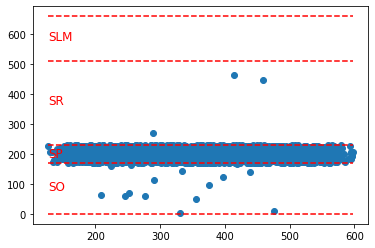

In [22]:
# plot the results
fig, ax = plt.subplots()
ax.scatter(x,y)
layer_heights = (0, 170, 230, 510, 660)
heights = (80, 190, 365, 580)
layers = ('SO', 'SP', 'SR', 'SLM')
ax.hlines(layer_heights, x.min(), x.max(), linestyle='--', colors='r')
for layer, height in zip(layers, heights):
    ax.text(x.min(), height, layer, fontsize=12, color='r')
fig.show()

### Exercise #1
The cell densities calculated above should be compared with literature. Extract data from literature (Aika et al 1994) and compare with the model.

![Aika_etal_1994_Table3](https://raw.githubusercontent.com/BlueBrain/MOOC-hippocampus-network-simulation-2019/master/notebooks/images/Aika_etal_1994_Table3.png)

__Hints__
The table provides more info than you need. For this exercise, focus only on the total number of cells in the entire CA1 and in the different layers. In addition to those 4 datapoints, consider also the PC density in SP.
Furthermore, note that Aika et al considered SLM and SR together (SRLM).

Store answer in two lists, one with data extracted from literature and one with data extrated from the model, each with the order density in CA1 - SRLM - SP - PC density in SP - SO.

### Exercise #2
Location for CCK and SOM cells. Answer will be a comma separated string from SLM to SO without space. For example, location of PV cells is 'SP'. Store answer in two lists, respectively for CCK and SOM.

### Exercise #3
Calculate density for PV, CCK, and SOM cells. Devide the number to the layer volume where they are present. Store answers in a list respecting the order PV, CCK, and SOM.

In [ ]:
# Work here 

In [ ]:
# This is to generate the answers to paste in the submission box below.
# Run this and copy-paste the output into the box below
print json.dumps(dict([("ans_1a", ans_1a),
                       ("ans_1b", ans_1b),
                       ("ans_2a", ans_2a),
                       ("ans_2b", ans_2b),
                       ("ans_3", ans_3)]))

!pip -q install -i https://bbpteam.epfl.ch/repository/devpi/simple/ single-cell-mooc-client==0.0.5 
import single_cell_mooc_client as sc_mc
s = sc_mc.Submission(hideToken=True)

In [ ]:
# Show submission widget
s.show_submission(ROLLBACK, TOKEN)